In [32]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
import rioxarray as rxr

local_files = {
    "predictions": Path("data/predictions_cog.tif"),
}

def load_predictions() -> xr.Dataset:
    """
    Load the model predictions array.

    This function loads the tif and processes it to be in the correct format for the dashboard.
    """
    predictions = rxr.open_rasterio(local_files["predictions"])
    predictions.coords["band"] = list(predictions.attrs["long_name"])
    # Set the nodata appropriately
    nodata = -1
    predictions = predictions.where(predictions >= 0, np.nan)

    # convert to a dataset to allow band name indexing
    predictions = predictions.to_dataset(dim="band")
    # Convert back to 0-1
    predictions = predictions / 100

    return predictions



def normalize(array:np.ndarray, vmin=None, vmax=None):
    """
    This function normalizes an array to be between 0 and 1.
    """
    if vmin is None or vmax is None:
        array = (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))
    else:
        # clip the values to the min and max
        array = array.clip(vmin, vmax)
        array = (array - vmin) / (vmax - vmin)
    return array


def array_to_rgb(array:np.ndarray, colormap="viridis", vmin=None, vmax=None):
    """
    This function converts an array to a RGB array using a colormap.
    """
    colormap_fn = get_cmap(colormap)
    # Normalize the band
    array = normalize(array, vmin, vmax)
    # apply the colormap to convert to RGD
    rgb = colormap_fn(array)
    return rgb

def write_tif_to_pngs(dataset:xr.Dataset, out_dir:Path, colormap="viridis", vmin=None, vmax=None, overwrite=False):
    """
    This function converts each band of a tif file to a RGB array and writes it to a PNG file.
    """
    # Get the band names
    band_names = dataset.data_vars.keys()
    output_paths  = []

    colormap_fn = get_cmap(colormap)
    # Loop through each band
    for band_name in band_names:
        out_path = out_dir/f"{band_name}.png"
        output_paths.append({band_name:out_path})

        if out_path.exists() and not overwrite:
            # Skip if the file already exists and user doesn't want to overwrite
            continue

        # Get the band
        band = dataset[band_name].values
        # flip the y axis to match the tif
        band = np.flipud(band)
        # Normalize the band
        band = normalize(band, vmin, vmax)
        # apply the colormap to convert to RGD
        rgb = colormap_fn(band)
        # Write the PNG file
        plt.imsave(out_path, rgb)
        

    return output_paths


In [33]:
predictions = load_predictions()

In [34]:
np.nanmean(predictions["Pipistrellus pipistrellus_All"].values)

0.14316756020054097

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  ...
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


/var/folders/w6/z6wv9w5s4r77c8m0lp63lm1w0000gp/T/ipykernel_61014/567234185.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap_fn = get_cmap(colormap)


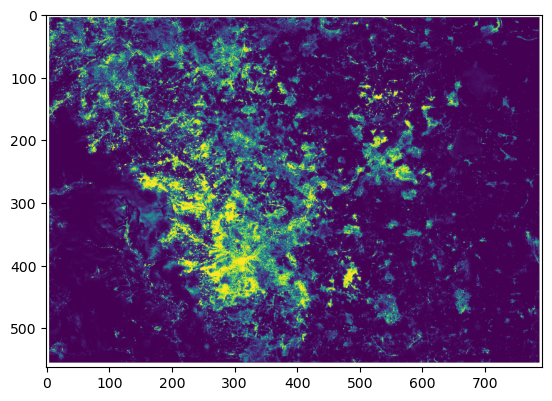

In [35]:
array = predictions["Pipistrellus pipistrellus_All"].values
# flip the y axis to match the tif
array = np.flipud(array)

rgb = array_to_rgb(array)

print(rgb)
#plot the RGB image
plt.imshow(rgb)

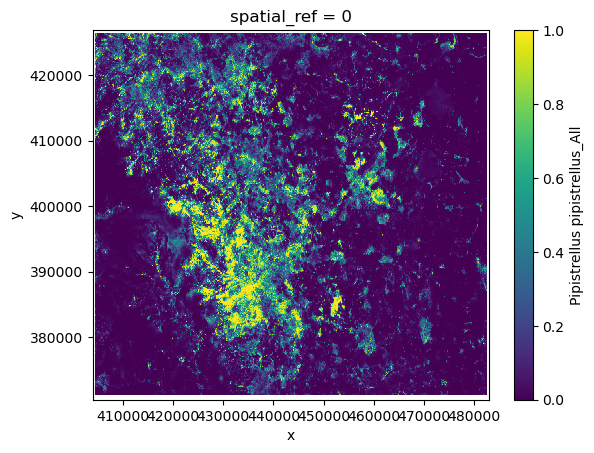

In [31]:
# plot the original xara array

predictions["Pipistrellus pipistrellus_All"].plot()